Uploaded dataset from Kaggle

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("fedesoriano/stroke-prediction-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/stroke-prediction-dataset


In [2]:
import time
import numpy as np
from numpy import mean
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
from collections import Counter
from scipy import stats
from scipy.stats.mstats import winsorize
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import RocCurveDisplay, roc_auc_score, auc, roc_curve, average_precision_score, precision_recall_curve
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from xgboost import XGBClassifier
import matplotlib.patches as mpatches
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import plot_importance
from sklearn.inspection import permutation_importance
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.datasets import make_classification
import lightgbm as lgb
from lightgbm import LGBMClassifier
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import PrecisionRecallCurve
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

%matplotlib inline

# **Loading Data and Data Review**

In [3]:
file_path = os.path.join(path, 'healthcare-dataset-stroke-data.csv')

In [4]:
df = pd.read_csv(file_path)
df.head(5)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [5]:
df.shape

(5110, 12)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,5110.0,36517.829354,21161.721625,67.00,17741.250,36932.000,54682.00,72940.00
age,5110.0,43.226614,22.612647,0.08,25.000,45.000,61.00,82.00
hypertension,5110.0,0.097456,0.296607,0.00,0.000,0.000,0.00,1.00
heart_disease,5110.0,0.054012,0.226063,0.00,0.000,0.000,0.00,1.00
avg_glucose_level,5110.0,106.147677,45.283560,55.12,77.245,91.885,114.09,271.74
bmi,4909.0,28.893237,7.854067,10.30,23.500,28.100,33.10,97.60
stroke,5110.0,0.048728,0.215320,0.00,0.000,0.000,0.00,1.00


# Preprocessing

Dropping id row as the id of the individual is not peritent to this study

In [8]:
df.drop('id', axis=1, inplace=True)

In [9]:
cat_columns = ["gender", "ever_married", "work_type", "Residence_type",
               "smoking_status"]

df = pd.get_dummies(df,dtype = 'int', columns=cat_columns, drop_first=True)

In [ ]:
#df['work_type'] = df['work_type'].replace(['Private','Self-employed',
                                          # 'children', 'Govt_job',
                                          # 'Never_worked'], [0,1,2,3,4])
#df['smoking_status'] = df['smoking_status'].replace(['never smoked',
                                                   #  'Unknown',
                                                    # 'formerly smoked',
                                                    # 'smokes'], [0,1,2,3])

In [10]:
df.head(5).T

,0,1,2,3,4
age,67.00,61.00,80.00,49.00,79.00
hypertension,0.00,0.00,0.00,0.00,1.00
heart_disease,1.00,0.00,1.00,0.00,0.00
avg_glucose_level,228.69,202.21,105.92,171.23,174.12
bmi,36.60,NaN,32.50,34.40,24.00
stroke,1.00,1.00,1.00,1.00,1.00
gender_Male,1.00,0.00,1.00,0.00,0.00
gender_Other,0.00,0.00,0.00,0.00,0.00
ever_married_Yes,1.00,1.00,1.00,1.00,1.00
work_type_Never_worked,0.00,0.00,0.00,0.00,0.00


#Handling missing values



In [11]:
miss_val = []

[miss_val.append(column) for column in df.columns if any(df[column].isnull())]

print("Columns that have missing values :")

miss_val

Columns that have missing values :


['bmi']

In [12]:
def first_looking(col):
    print("column name    : ", col)
    print("--------------------------------")
    print("per_of_nulls   : ", "%", round(df[col].isnull().sum()*100 / df.shape[0], 2))
    print("num_of_nulls   : ", df[col].isnull().sum())
    print("num_of_uniques : ", df[col].nunique())
    print("--------------------------------")
    print(df[col].value_counts(dropna = False))

In [13]:
first_looking('bmi')


column name    :  bmi
--------------------------------
per_of_nulls   :  % 3.93
num_of_nulls   :  201
num_of_uniques :  418
--------------------------------
bmi
NaN     201
28.7     41
28.4     38
27.6     37
26.1     37
       ... 
47.9      1
13.0      1
46.3      1
54.1      1
14.9      1
Name: count, Length: 419, dtype: int64


In [14]:
def fill_most_freq(df, group_col, col_name):
  for group in list(df[group_col].unique()):
    cond = df[group_col]==group
    mode = list(df[cond][col_name].mode())
    if mode != []:
      df.loc[cond, col_name] = df.loc[cond, col_name].fillna(df[cond][col_name].mode()[0])
    else:
      df.loc[cond, col_name] = df.loc[cond, col_name].fillna(df[col_name].mode()[0])
  print('Number of NaN : ', df[col_name].isnull().sum())
  print('------------------')
  print(df[col_name].value_counts(dropna=False))

In [15]:
df.loc[df['bmi'] > 60, 'bmi'] = np.nan

In [16]:
fill_most_freq(df, 'age' ,'bmi')
#check gender, or age to fill in missing values
#gender provides a larger distribution of values vs using age for filling values

Number of NaN :  0
------------------
bmi
28.7    49
28.4    42
23.4    41
27.6    41
27.0    40
        ..
48.1     1
51.7     1
46.3     1
54.1     1
14.9     1
Name: count, Length: 406, dtype: int64


In [21]:
df.bmi.isnull().sum()

np.int64(0)

In [20]:
df[df.bmi>60].bmi != np.nan

,bmi


#Explorative Data Analysis

These three use pie charts, binary data always pie charts or bar charts####

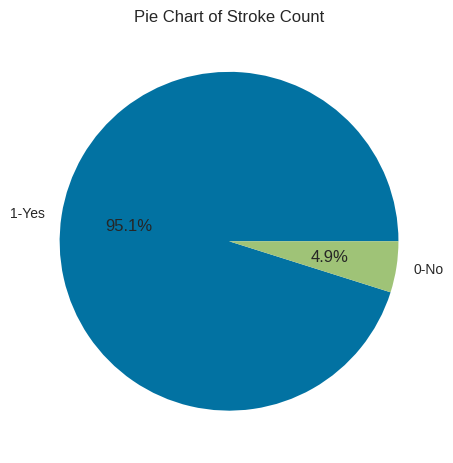

In [22]:
df.stroke.value_counts()
labels = '1-Yes', '0-No'

plt.pie(df.stroke.value_counts(), labels=labels, autopct='%1.1f%%')
plt.title('Pie Chart of Stroke Count')
plt.show()

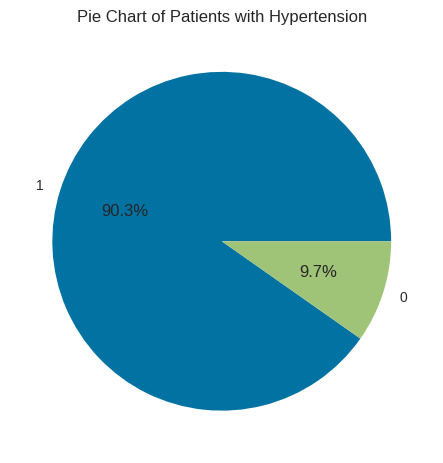

In [23]:
df.hypertension.value_counts()

labels = '1', '0'

plt.pie(df.hypertension.value_counts(), labels=labels, autopct='%1.1f%%')
plt.title('Pie Chart of Patients with Hypertension')
plt.show()

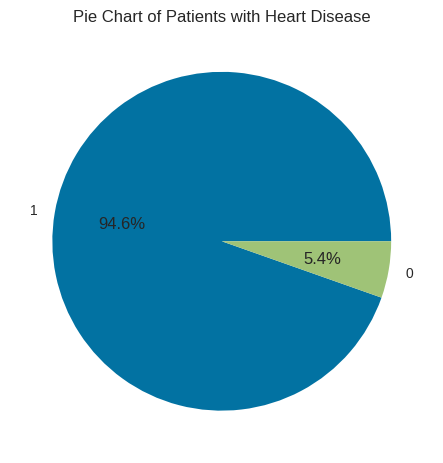

In [24]:
df.heart_disease.value_counts()
labels = '1', '0'

plt.pie(df.heart_disease.value_counts(), labels=labels, autopct='%1.1f%%')
plt.title('Pie Chart of Patients with Heart Disease')
plt.show()

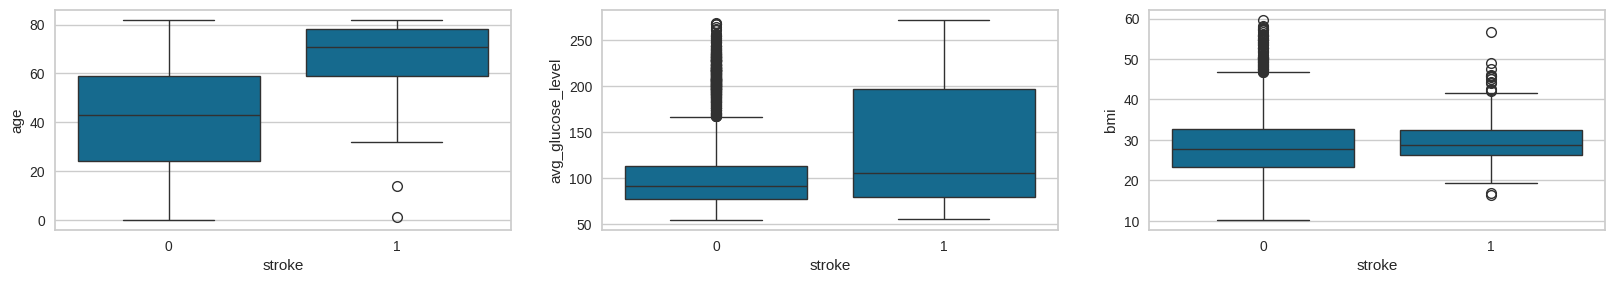

In [25]:
index = 0
plt.figure(figsize=(20,20))
num_cols = df.shape[1] -1
num_rows = (num_cols + 2) //3
for feature in ['age','avg_glucose_level','bmi']:
    if feature != "stroke":
        index += 1
        plt.subplot(num_rows,3,index)
        #if feature in ['age','heart_disease','avg_glucose_level','bmi']:
        sns.boxplot(x='stroke',y=feature,data=df)

The three boxplots above show the relation between Stroke and Age/Avg Glucose Level/BMI. The Stroke/Age boxplot suggests the patients referenced in this data who are older than 60 are at higher risk to have strokes. The median for the BMI boxplot is nearly the same while patients with strokes having a slightly higher BMI but the patients without a stroke having a larger spread. The boxplot with average glucose level indicates that patients who have a stroke have a wider range of glucose levels however there are several outliers with patients with no stroke.

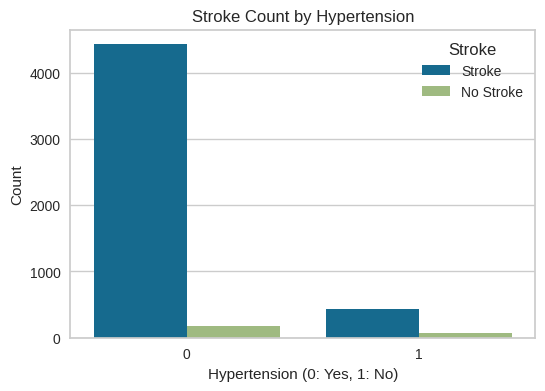

In [26]:
plt.figure(figsize=(6,4))
sns.countplot(x="hypertension", hue="stroke", data=df)
plt.xlabel("Hypertension (0: Yes, 1: No)")
plt.ylabel("Count")
plt.title("Stroke Count by Hypertension")
plt.legend(title="Stroke", labels=["Stroke", "No Stroke"])


plt.show()

The graph shows that there is high risk for stroke among patients that have Hypertension which tracks with industry data of patients with "High blood pressure can lead to stroke in different ways. "

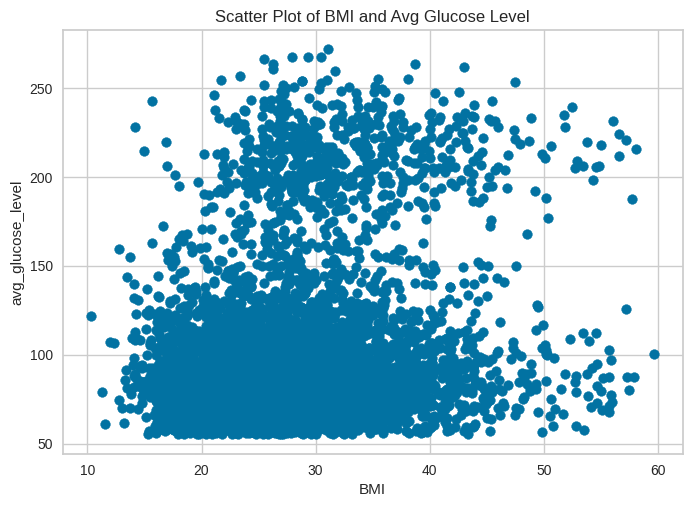

In [27]:
plt.scatter(data=df, x='bmi', y='avg_glucose_level')

plt.title('Scatter Plot of BMI and Avg Glucose Level')
plt.xlabel('BMI')
plt.ylabel('avg_glucose_level')


plt.show()

The scatter plot shows a dense population of patients with a average glucose level below 150 and a wide array of BMI from 15-45. As the data suggests, the average patient has a average glucose level lower than 150.

Scatter plot with color based on 'stroke' (categorical)

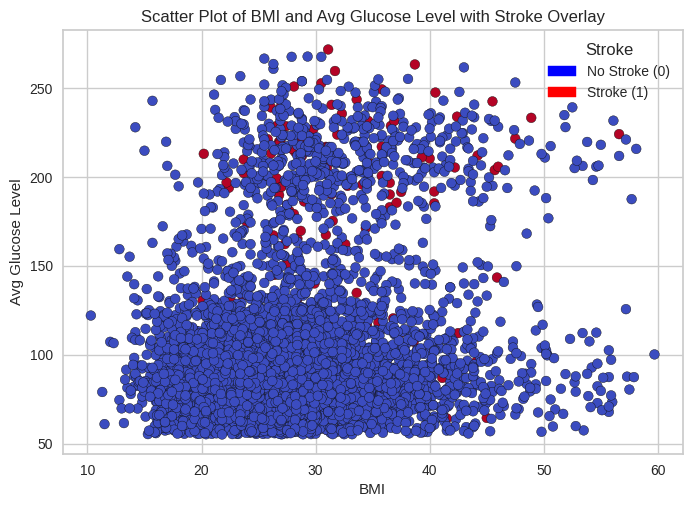

In [28]:
plt.scatter(data=df, x='bmi', y='avg_glucose_level', c=df['stroke'],
            cmap='coolwarm', edgecolors='k')

plt.title('Scatter Plot of BMI and Avg Glucose Level with Stroke Overlay')
plt.xlabel('BMI')
plt.ylabel('Avg Glucose Level')

no_stroke_patch = mpatches.Patch(color='blue', label='No Stroke (0)')
stroke_patch = mpatches.Patch(color='red', label='Stroke (1)')
plt.legend(handles=[no_stroke_patch, stroke_patch], title='Stroke',
           loc='upper right')

plt.show()

The graph with Stroke results overlay is not as descriptive as anticipated. However the data does follow the data produced in the first scatter plot, showing that patients with a glucose level under 150 are having strokes.

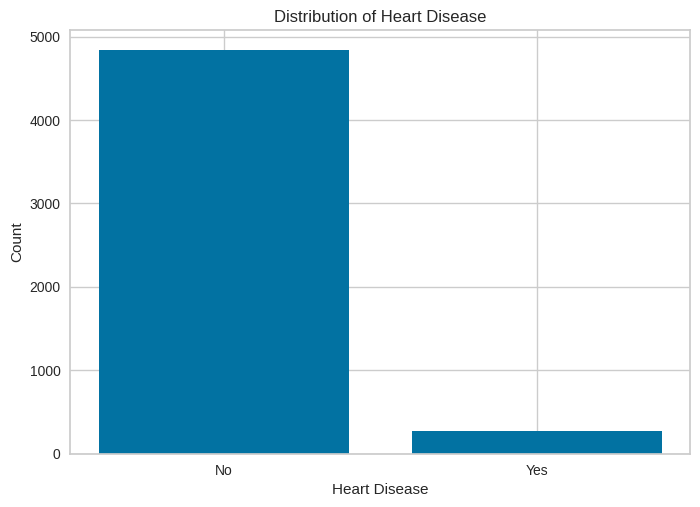

In [29]:
heart_disease_counts = df['heart_disease'].value_counts()
plt.bar(heart_disease_counts.index, heart_disease_counts.values)
plt.xlabel("Heart Disease")
plt.ylabel("Count")
plt.title("Distribution of Heart Disease")
plt.xticks(heart_disease_counts.index, ['No', 'Yes'])  # Assuming 0 represents No and 1 represents Yes
plt.show()

The histogram above shows the count of patients with Heart Disease and without Heart Disease. The vast majority of patients do not have Heart Disease.

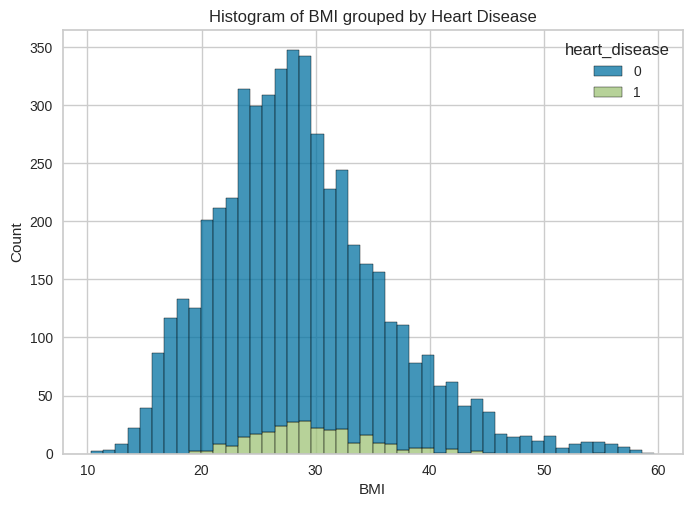

In [30]:
sns.histplot(data=df, x='bmi', hue='heart_disease', multiple='stack')

plt.title('Histogram of BMI grouped by Heart Disease')
plt.xlabel('BMI')
plt.show()

The Histogram shows the majority of patients with a moderately high to high number for BMI are also at higher risk for having heart disease.

#SCALING the data

In [31]:
X=df.drop(["stroke"], axis=1)
y=df["stroke"]

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,
                                                     random_state=42)

In [33]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X_train)
scaled_data_test = scaler.transform(X_test)


#Function for evolution metric

In [34]:
def eval_metric(model, X_train, y_train, X_test, y_test):
    # Predicting on train and test sets
    y_pred_train = model.predict(X_train)
    y_pred = model.predict(X_test)

    # AUC calculation (for binary classification)
    y_prob_train = model.predict_proba(X_train)[:, 1]  # Probability estimates for the positive class
    y_prob = model.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class

    auc_train = roc_auc_score(y_train, y_prob_train)
    auc_test = roc_auc_score(y_test, y_prob)

    print('Test_Set')
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print('AUC (Test Set):', auc_test)
    print('------------------------------------')
    print('Train_Set')
    print(confusion_matrix(y_train, y_pred_train))
    print(classification_report(y_train, y_pred_train))
    print('AUC (Train Set):', auc_train)
    print('------------------------------------')

##SMOTE Modeling using RandomForest

SMOTE Increases the number of minority class samples through interpolation, improving the generalization ability of classifiers.

In [35]:
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
	n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)

k_values = [5] #Highest result with 5

#pipeline for SMOTE
for k in k_values:
	model = RandomForestClassifier()
	over = SMOTE(sampling_strategy=0.1, k_neighbors=k)
	under = RandomUnderSampler(sampling_strategy=0.5)
	steps = [('over', over), ('under', under), ('model', model)]
	pipeline = Pipeline(steps=steps)
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
	score = mean(scores)
	print('> k=%d, Mean ROC AUC: %.3f' % (k, score))

> k=5, Mean ROC AUC: 0.936


##SMOTENC model using RandomForest

SMOTE Nominal Continuous Handles mixed data types without distorting the categorical feature space.

In [36]:
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
	n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)

k_values = [1,2,3,4,5,6] #highest result with 6
categorical_features = [0]

#pipeline for SMOTENC
for k in k_values:
	model = RandomForestClassifier()
	over = SMOTENC(categorical_features=categorical_features,
                sampling_strategy=0.05,
                random_state=42)
	under = RandomUnderSampler(sampling_strategy=0.7)
	steps = [('over', over), ('under', under), ('model', model)]
	pipeline = Pipeline(steps=steps)
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
	score = mean(scores)
	print('> k=%d, Mean ROC AUC: %.3f' % (k, score))

> k=1, Mean ROC AUC: 0.940
> k=2, Mean ROC AUC: 0.939
> k=3, Mean ROC AUC: 0.942
> k=4, Mean ROC AUC: 0.935
> k=5, Mean ROC AUC: 0.944
> k=6, Mean ROC AUC: 0.933


##SMOTE model using XGB Classifier

In [37]:
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
	n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)

k_values = [5] #highest result with 5

#pipeline for SMOTE
for k in k_values:
	model = XGBClassifier()
	over = SMOTE(sampling_strategy=0.1, k_neighbors=k)
	under = RandomUnderSampler(sampling_strategy=0.5)
	steps = [('over', over), ('under', under), ('model', model)]
	pipeline = Pipeline(steps=steps)
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
	score = mean(scores)
	print('> k=%d, Mean ROC AUC: %.3f' % (k, score))

> k=5, Mean ROC AUC: 0.930


##SMOTENC model using XGB Classifier

In [38]:
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
	n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)

k_values = [1,2,3,4,5,6] #highest result with 3
categorical_features = [0]

#pipeline for SMOTENC
for k in k_values:
	model = XGBClassifier()
	over = SMOTENC(categorical_features=categorical_features,
                sampling_strategy=0.05,
                random_state=42)
	under = RandomUnderSampler(sampling_strategy=0.7)
	steps = [('over', over), ('under', under), ('model', model)]
	pipeline = Pipeline(steps=steps)
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
	score = mean(scores)
	print('> k=%d, Mean ROC AUC: %.3f' % (k, score))

> k=1, Mean ROC AUC: 0.929
> k=2, Mean ROC AUC: 0.927
> k=3, Mean ROC AUC: 0.934
> k=4, Mean ROC AUC: 0.930
> k=5, Mean ROC AUC: 0.935
> k=6, Mean ROC AUC: 0.935


#Modeling

##Logistic Regression

In [39]:
log_model = LogisticRegression(class_weight='balanced')

In [40]:
log_model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

In [41]:
print('Log Model')
eval_metric(log_model, X_train, y_train, X_test, y_test)

Log Model
Test_Set
[[713 247]
 [ 14  48]]
              precision    recall  f1-score   support

           0       0.98      0.74      0.85       960
           1       0.16      0.77      0.27        62

    accuracy                           0.74      1022
   macro avg       0.57      0.76      0.56      1022
weighted avg       0.93      0.74      0.81      1022

AUC (Test Set): 0.8514448924731182
------------------------------------
Train_Set
[[2857 1044]
 [  35  152]]
              precision    recall  f1-score   support

           0       0.99      0.73      0.84      3901
           1       0.13      0.81      0.22       187

    accuracy                           0.74      4088
   macro avg       0.56      0.77      0.53      4088
weighted avg       0.95      0.74      0.81      4088

AUC (Train Set): 0.8435297681795563
------------------------------------


Text(168.97222222222223, 0.5, 'Predicted Stroke')

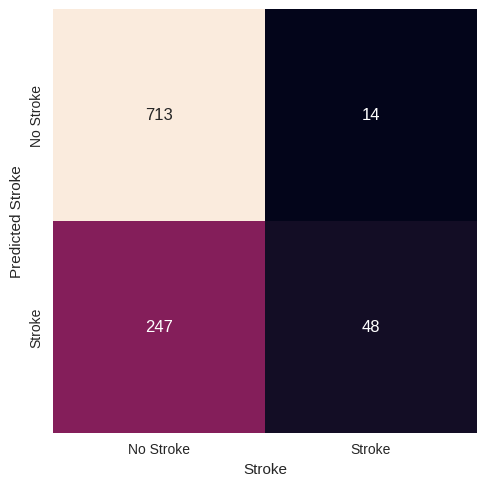

In [42]:
yfit = log_model.predict(X_test)
mat = confusion_matrix(y_test, yfit)
sns.heatmap(mat.T, square=True, annot=True,fmt='d',cbar=False,
            xticklabels=['No Stroke', 'Stroke'],
            yticklabels=['No Stroke','Stroke'])
plt.xlabel('Stroke')
plt.ylabel('Predicted Stroke')

The heatmap shows that the predicted strokes data aligns with patients with no strokes. Showing the predictive analysis to be effective in predicting strokes in patients.

In [43]:
scoring = {'precision-neg': make_scorer(precision_score,average='binary',),
           'recall-neg': make_scorer(recall_score,average='binary',),
           'f1-neg': make_scorer(f1_score,average='binary')}

In [44]:
scores = cross_validate(log_model, X_train, y_train, scoring = scoring, cv=10)
df_scores = pd.DataFrame(scores, index = range(1,11))
df_scores.mean()[2:]

,0
test_precision-neg,0.124306
test_recall-neg,0.801462
test_f1-neg,0.215106


In [45]:
y_pred=log_model.predict(X_train)

In [46]:
y_pred

array([1, 1, 0, ..., 0, 1, 0])

In [47]:
y_pred_train=log_model.predict(X_train)

In [48]:
y_pred_train

array([1, 1, 0, ..., 0, 1, 0])

#Logistic Regression Finetuning

In [49]:
param_grid = {
    'C': [1.75],  # Regularization strength, (1,1.5,2,2.5,3)
    'penalty': ['l1', 'l2'],  # Regularization type
    'solver': ['liblinear', 'saga'],  # Solvers suitable for small datasets
    'max_iter': [200]  # Maximum number of iterations(100,150,200,250,300,350,400)
}


grid_search = GridSearchCV(estimator=log_model, param_grid=param_grid,
                           cv=5, scoring='roc_auc')


grid_search.fit(X_train, y_train)

# Print the best parameters found by GridSearchCV
print("Best Parameters:", grid_search.best_params_)

# Get the best model from GridSearchCV
best_log_model = grid_search.best_estimator_

Best Parameters: {'C': 1.75, 'max_iter': 200, 'penalty': 'l1', 'solver': 'liblinear'}


In [50]:
eval_metric(best_log_model, X_train, y_train, X_test, y_test)

Test_Set
[[722 238]
 [ 15  47]]
              precision    recall  f1-score   support

           0       0.98      0.75      0.85       960
           1       0.16      0.76      0.27        62

    accuracy                           0.75      1022
   macro avg       0.57      0.76      0.56      1022
weighted avg       0.93      0.75      0.82      1022

AUC (Test Set): 0.8531586021505376
------------------------------------
Train_Set
[[2885 1016]
 [  35  152]]
              precision    recall  f1-score   support

           0       0.99      0.74      0.85      3901
           1       0.13      0.81      0.22       187

    accuracy                           0.74      4088
   macro avg       0.56      0.78      0.54      4088
weighted avg       0.95      0.74      0.82      4088

AUC (Train Set): 0.8455805243959111
------------------------------------


The Logistic regression model shows a Test AUC score of 85 and a Train AUC set of 84. The parameters (C=1.75, L1, liblinear, with 200 iterations) used in the best log model shows the highest scores compared to other parameters.

#ROC Curve using Log model

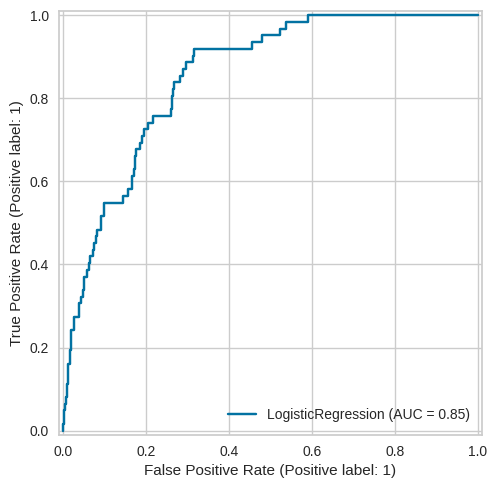

In [51]:
RocCurveDisplay.from_estimator(best_log_model, X_test, y_test)

The ROC Curve using Logistic Regression model shows high sensitivity indicating the TPR is close to one and has a low false positive rate. This curve indicates that the log model is effective for this data.

#SVM modelling

In [52]:
svc = SVC(C=1,class_weight = 'balanced', probability=True)
svc.fit(X_train, y_train)


SVC(C=1, class_weight='balanced', probability=True)

In [ ]:
start = time.time()
#param_grid = {
    'C': [0.1, 1,10],
    'kernel': ['linear', 'rbf', 'sigmoid'],
    'gamma': ['auto'],
    'degree': [2,3]
}


#grid_search = GridSearchCV(estimator= svc, param_grid=param_grid,
                           cv=5, scoring='roc_auc')


#grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

best_svc_model = grid_search.best_estimator_
end = time.time()
print("Single SVC", end - start)

The SVM model takes significant run time to calculate. This model is not the most efficient for time sensitive analysis.

In [53]:
print('SVC Model')
eval_metric(svc, X_train, y_pred_train, X_test,y_test)

SVC Model
Test_Set
[[711 249]
 [ 17  45]]
              precision    recall  f1-score   support

           0       0.98      0.74      0.84       960
           1       0.15      0.73      0.25        62

    accuracy                           0.74      1022
   macro avg       0.56      0.73      0.55      1022
weighted avg       0.93      0.74      0.81      1022

AUC (Test Set): 0.8356014784946236
------------------------------------
Train_Set
[[2747  145]
 [  99 1097]]
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      2892
           1       0.88      0.92      0.90      1196

    accuracy                           0.94      4088
   macro avg       0.92      0.93      0.93      4088
weighted avg       0.94      0.94      0.94      4088

AUC (Train Set): 0.9834267752813666
------------------------------------


Overfitting problem with this data, please see the Test set and Train set. However due to long run times the model has not been fine tuned.

#ROC Curve using SVC Model

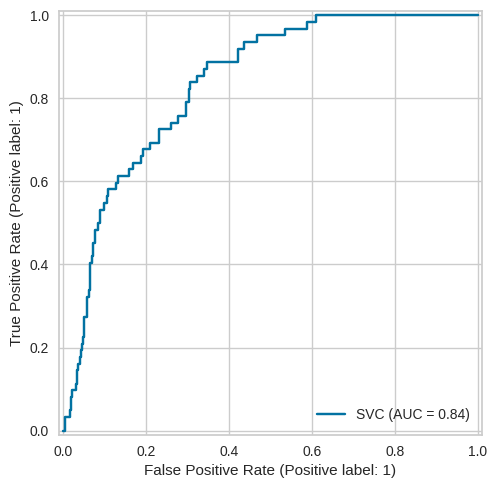

In [54]:
RocCurveDisplay.from_estimator(svc, X_test, y_test)

The ROC Curve using SVC is showing good performance for this model however this model has not been fine tuned due to execessive run times. This graph could be showing us a false TPR. Better to use the Log model at this point in the project.

XGB model

In [55]:
pos_count = sum(y_train == 1)

neg_count = sum(y_train == 0)

scale_pos_weight = neg_count / pos_count

In [56]:
xgb_model = XGBClassifier(random_state=101,scale_pos_weight=scale_pos_weight)

xgb_model.fit(X_train, y_train)
eval_metric(xgb_model, X_train, y_train, X_test, y_test)

Test_Set
[[925  35]
 [ 53   9]]
              precision    recall  f1-score   support

           0       0.95      0.96      0.95       960
           1       0.20      0.15      0.17        62

    accuracy                           0.91      1022
   macro avg       0.58      0.55      0.56      1022
weighted avg       0.90      0.91      0.91      1022

AUC (Test Set): 0.7748823924731183
------------------------------------
Train_Set
[[3887   14]
 [   0  187]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3901
           1       0.93      1.00      0.96       187

    accuracy                           1.00      4088
   macro avg       0.97      1.00      0.98      4088
weighted avg       1.00      1.00      1.00      4088

AUC (Train Set): 1.0
------------------------------------


Overfitting problem for XGB due to large difference in training and test data, explain this in presentation

In [57]:
param_grid = {
    'n_estimators': [125,100,175],  # Number of trees(100,125,150,175,200,225,250)
    'learning_rate': [0.04,0.05],  # Step size for each iteration(0.01-0.07)
    'max_depth': [2,1.5,2.5,2.2],  # Maximum depth of each tree(1,1.5,2,2.25,2.5,3)
    'subsample': [1.0,0.9],  # Fraction of samples to use for each tree
    'colsample_bytree': [1.0],  # Fraction of features to use for each tree(0.5-1.5)
    'scale_pos_weight': [17,18,19]  # For handling class imbalance (16-25)
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid,
                           cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

best_xgb_model = grid_search.best_estimator_

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 125, 'scale_pos_weight': 18, 'subsample': 1.0}


In [58]:
eval_metric(best_xgb_model, X_train, y_pred_train, X_test,y_test)

Test_Set
[[724 236]
 [ 11  51]]
              precision    recall  f1-score   support

           0       0.99      0.75      0.85       960
           1       0.18      0.82      0.29        62

    accuracy                           0.76      1022
   macro avg       0.58      0.79      0.57      1022
weighted avg       0.94      0.76      0.82      1022

AUC (Test Set): 0.8548135080645162
------------------------------------
Train_Set
[[2792  100]
 [ 148 1048]]
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      2892
           1       0.91      0.88      0.89      1196

    accuracy                           0.94      4088
   macro avg       0.93      0.92      0.93      4088
weighted avg       0.94      0.94      0.94      4088

AUC (Train Set): 0.9820374334457411
------------------------------------


Overfitting problem still exsists however the previous function did allow the parameters to bring the test score up to 85 and decrease the train score to 98.

In [59]:
y_pred = xgb_model.predict(X_test)
predictions = [round(value) for value in y_pred]

In [60]:
accuracy = accuracy_score(y_test, predictions)
print('Accuracy: %.2f%%' % (accuracy * 100.00))

Accuracy: 91.39%


#ROC Curve using XGB

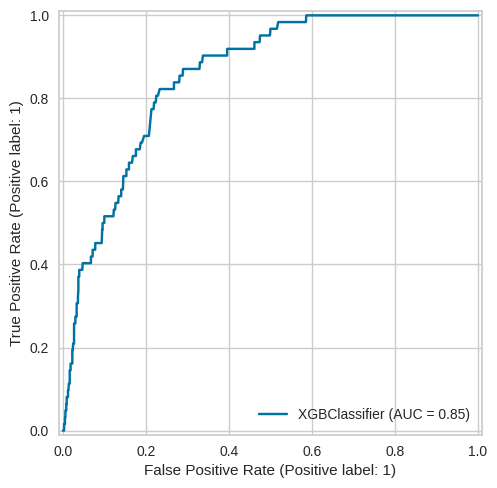

In [61]:
RocCurveDisplay.from_estimator(best_xgb_model, X_test, y_test)

The ROC Curve using XGB shows an increase in performance compared to the two previous ROC Curves. The TPR is closer to following 1 while the other two models show a TPR closer to a random classifier indicating a better performing model.

Light GBM model

In [62]:
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test,reference=train_data)

In [63]:
param_grid = {
    "objective": ["binary"],
    "boosting_type": ["rf"],
    "num_leaves": [3,4,5,6,7],
    "force_row_wise": [True],
    "learning_rate": [0.4,0.3,0.5],
    "metric": ["binary_logloss"],
    "bagging_fraction": [0.5,0.7,0.8,0.4],
    "feature_fraction": [0.5,0.6,0.7]
}

lgb_classifier = LGBMClassifier(class_weight = 'balanced')

grid_search = GridSearchCV(estimator=lgb_classifier, param_grid=param_grid,
                           cv=5, scoring='recall', n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

best_lgb_model = grid_search.best_estimator_

Fitting 5 folds for each of 180 candidates, totalling 900 fits
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Info] Number of positive: 187, number of negative: 3901
[LightGBM] [Info] Total Bins 635
[LightGBM] [Info] Number of data points in the train set: 4088, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Best Parameters: {'bagging_fraction': 0.5, 'boos

In [64]:
eval_metric(best_lgb_model, X_train, y_pred_train, X_test,y_test)

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
Test_Set
[[555 405]
 [  4  58]]
    

After finetuning with different parameters, this model still shows an overfitting problem larger than previous models.

In [65]:
num_round = 500
params = grid_search.best_params_
params["objective"] = "binary"
bst = lgb.train(params, train_data, num_round, valid_sets = [test_data])

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 187, number of negative: 3901
[LightGBM] [Info] Total Bins 635
[LightGBM] [Info] Number of data points in the train set: 4088, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.045744 -> initscore=-3.037880
[LightGBM] [Info] Start training from score -3.037880
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


In [66]:
y_pred = bst.predict(X_test)

y_pred_binary = (y_pred > 0.5).astype(int)

auc_roc = roc_auc_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1score = f1_score(y_test, y_pred_binary)

print(f'AUC_ROC: {auc_roc:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1score: {f1score:.4f}')


AUC_ROC: 0.5000
Precision: 0.0000
Recall: 0.0000
F1score: 0.0000


In [67]:
lgb_report = classification_report(y_test, y_pred_binary)
print(lgb_report)

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       960
           1       0.00      0.00      0.00        62

    accuracy                           0.94      1022
   macro avg       0.47      0.50      0.48      1022
weighted avg       0.88      0.94      0.91      1022



KNN model

In [68]:
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train)


KNeighborsClassifier(n_neighbors=7)

In [69]:
print('KNN Model')
eval_metric(knn, X_train, y_train, X_test, y_test)

KNN Model
Test_Set
[[957   3]
 [ 61   1]]
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       960
           1       0.25      0.02      0.03        62

    accuracy                           0.94      1022
   macro avg       0.60      0.51      0.50      1022
weighted avg       0.90      0.94      0.91      1022

AUC (Test Set): 0.7204721102150538
------------------------------------
Train_Set
[[3900    1]
 [ 184    3]]
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      3901
           1       0.75      0.02      0.03       187

    accuracy                           0.95      4088
   macro avg       0.85      0.51      0.50      4088
weighted avg       0.95      0.95      0.93      4088

AUC (Train Set): 0.9280837081401039
------------------------------------


Large overfitting problem with this model as is expected. The model might be a little closer with some finetuning.

In [70]:
grid_params = { 'n_neighbors' : [3,5,7],
               'weights' : ['distance'],
               'metric' : ['minkowski','euclidean','manhattan']}

gs = GridSearchCV(KNeighborsClassifier(weights='distance'), grid_params, verbose = 1, cv=3, scoring ='recall',
                  n_jobs = -1)

gs.fit(X_train, y_train)

print("Best Parameters:", gs.best_params_)

best_knn_model = gs.best_estimator_

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best Parameters: {'metric': 'minkowski', 'n_neighbors': 3, 'weights': 'distance'}


In [71]:
eval_metric(best_knn_model, X_train, y_pred_train, X_test,y_test)

Test_Set
[[952   8]
 [ 59   3]]
              precision    recall  f1-score   support

           0       0.94      0.99      0.97       960
           1       0.27      0.05      0.08        62

    accuracy                           0.93      1022
   macro avg       0.61      0.52      0.52      1022
weighted avg       0.90      0.93      0.91      1022

AUC (Test Set): 0.652898185483871
------------------------------------
Train_Set
[[2857   35]
 [1044  152]]
              precision    recall  f1-score   support

           0       0.73      0.99      0.84      2892
           1       0.81      0.13      0.22      1196

    accuracy                           0.74      4088
   macro avg       0.77      0.56      0.53      4088
weighted avg       0.76      0.74      0.66      4088

AUC (Train Set): 0.5676242731650454
------------------------------------


The training and test data do show more overfitting however the gap has decreased with the finetuning. This model is still not the most effective as you will observe with the Recall and ROC Curve

Recall Curve for KNN

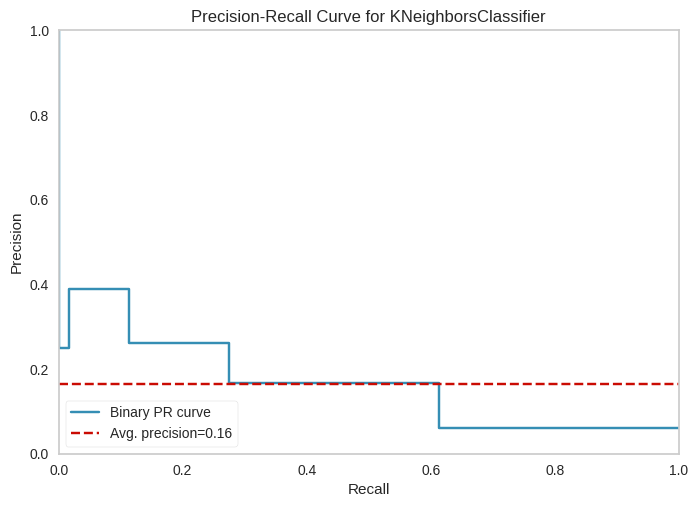

<Axes: title={'center': 'Precision-Recall Curve for KNeighborsClassifier'}, xlabel='Recall', ylabel='Precision'>

In [72]:
viz = PrecisionRecallCurve(
    KNeighborsClassifier(n_neighbors=7),
    classes=knn.classes_,
    per_class=True,
    cmap='Set1'
)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show()

ROC curve using KNN model

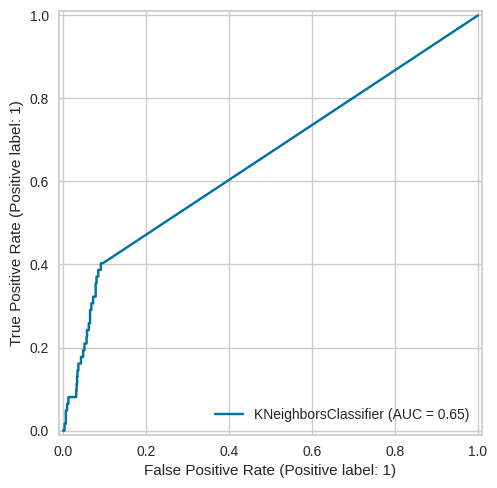

In [73]:
best_knn_model.fit(X_train,y_train)
RocCurveDisplay.from_estimator(best_knn_model, X_test, y_test)

The ROC Curve using KNN's TPR is closer to 0.5. The TPR for the KNN model is not close to 1 indicating the model is only slightly better than a random classifier. The other model's performances are stronger and quicker.

##Random Forest Model

In [74]:
rf_model = RandomForestClassifier(random_state=101,class_weight='balanced')
                           #class_weight='balanced')
rf_model.fit(X_train, y_train)
eval_metric(rf_model,X_train, y_train, X_test, y_test)

Test_Set
[[960   0]
 [ 62   0]]
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       960
           1       0.00      0.00      0.00        62

    accuracy                           0.94      1022
   macro avg       0.47      0.50      0.48      1022
weighted avg       0.88      0.94      0.91      1022

AUC (Test Set): 0.8034778225806452
------------------------------------
Train_Set
[[3901    0]
 [   0  187]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3901
           1       1.00      1.00      1.00       187

    accuracy                           1.00      4088
   macro avg       1.00      1.00      1.00      4088
weighted avg       1.00      1.00      1.00      4088

AUC (Train Set): 1.0
------------------------------------


The Random Forest model shows a significant amount of overfitting.

In [75]:
grid_params = { 'n_estimators' : [100],
               'max_depth' : [4],
               'min_samples_split': [1,3],  # Minimum number of samples required to split an internal node
               'min_samples_leaf': [3,5]
}

gs = GridSearchCV(RandomForestClassifier(class_weight = 'balanced'), grid_params, verbose = 1, cv=3, scoring ='recall',
                  n_jobs = -1)

gs.fit(X_train, y_train)

print("Best Parameters:", gs.best_params_)

best_rf_model = gs.best_estimator_

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best Parameters: {'max_depth': 4, 'min_samples_leaf': 5, 'min_samples_split': 3, 'n_estimators': 100}


AUC score normally is 85.124 and Recall is 90

In [76]:
eval_metric(best_rf_model,X_train, y_train, X_test, y_test)

Test_Set
[[710 250]
 [  9  53]]
              precision    recall  f1-score   support

           0       0.99      0.74      0.85       960
           1       0.17      0.85      0.29        62

    accuracy                           0.75      1022
   macro avg       0.58      0.80      0.57      1022
weighted avg       0.94      0.75      0.81      1022

AUC (Test Set): 0.8525117607526882
------------------------------------
Train_Set
[[2843 1058]
 [  25  162]]
              precision    recall  f1-score   support

           0       0.99      0.73      0.84      3901
           1       0.13      0.87      0.23       187

    accuracy                           0.74      4088
   macro avg       0.56      0.80      0.54      4088
weighted avg       0.95      0.74      0.81      4088

AUC (Train Set): 0.8805646982057254
------------------------------------


The overfitting with the Random Forest model appears to eliminated for the most part with the help of fine tuning. The Train and test set are close but not as close as previous models. Indicating that Random Forest is not the best model to choose for this data. The run time for this model is longer than most.

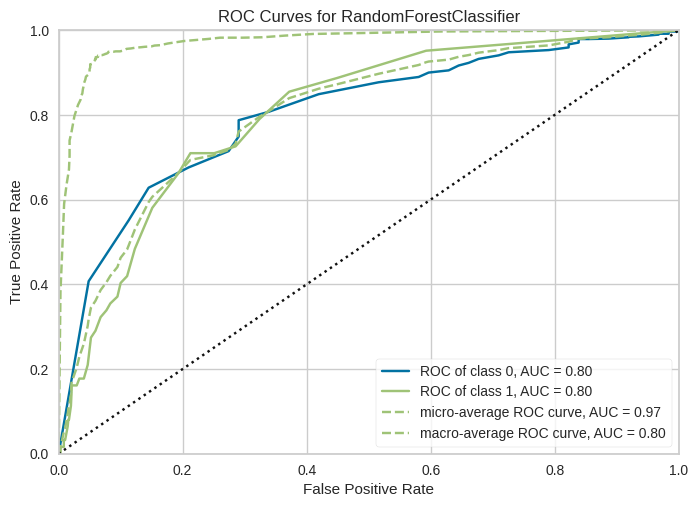

<Axes: title={'center': 'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [77]:
rf_model_2 = RandomForestClassifier()
visualizer = ROCAUC(rf_model_2)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

The ROC Curve above is using the model with the overfitting issue as indicated by the TPR being closer to the random classifier.

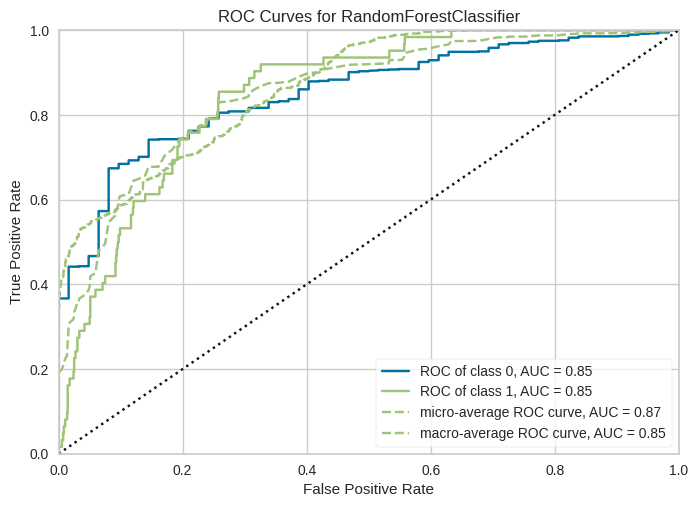

<Axes: title={'center': 'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [78]:
rf_model_2 = RandomForestClassifier()
visualizer = ROCAUC(best_rf_model)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

The data in this graph shows how the overfitting for Random Forest helped improve the TPR to almost follow along 1. The improved performanced is noted however this model is still not the best.

##Comparing Models


In [79]:
models = {
    "Random Forest": best_rf_model,
    "KNN": best_knn_model,
    "LightGBM": best_lgb_model,
    "XGBoost": best_xgb_model,
    "SVC": svc,
    "Logistic Regression": best_log_model
}

results = []

for model_name, model in models.items():
  if model_name == 'LightGBM':
    y_pred = model.predict(X_test)
    y_pred_binary = (y_pred > 0.5).astype(int)
    #accuracy = accuracy_score(y_test, y_pred_binary)
    #precision = precision_score(y_test, y_pred_binary)
    AUC = roc_auc_score(y_test, y_pred_binary)
    recall = recall_score(y_test, y_pred_binary)
    f1score = f1_score(y_test, y_pred_binary)
  else:
    y_pred = model.predict(X_test)
    #accuracy = accuracy_score(y_test, y_pred)
    #precision = precision_score(y_test, y_pred)
    AUC = roc_auc_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
  results.append([model_name,AUC, recall, f1])

results_df = pd.DataFrame(results, columns=["Model","AUC",
                                            "Recall", "F1-Score"])

print(results_df)

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
                 Model       AUC    Recall  F1-Score
0        Random Forest  0.797211  0.854839  0.290411
1                  KNN  0.520027  0.048387  0.082192
2             LightGBM  0.756804  0.935484  0.082192
3              XGBoost  0.788374  0.822581  0.292264
4                  SVC  0.733216  0.725806  0.252809
5  Logistic Regression  0.755074  0.758065  0.270893


In [80]:
result_test = results_df.iloc[1::2]

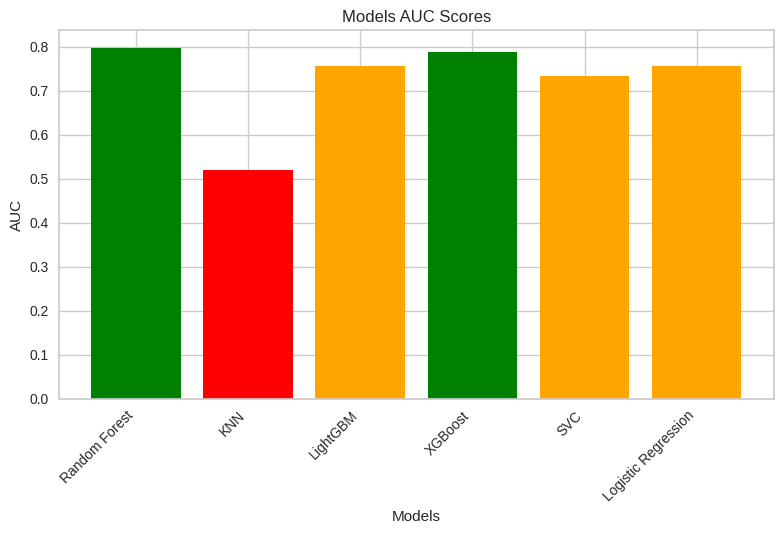

In [81]:
Models = list(models.keys())
AUC = results_df['AUC'].tolist()

color = ['green', 'red', 'orange','green', 'orange','orange']


plt.bar(Models, AUC, color=color,)
plt.title('Models AUC Scores')
plt.xlabel('Models')
plt.ylabel('AUC')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

The above bar graph is comparing the AUC scores of all the models. As you can see the two green bars (SVC and Logistic Regression) show the best AUC performance.

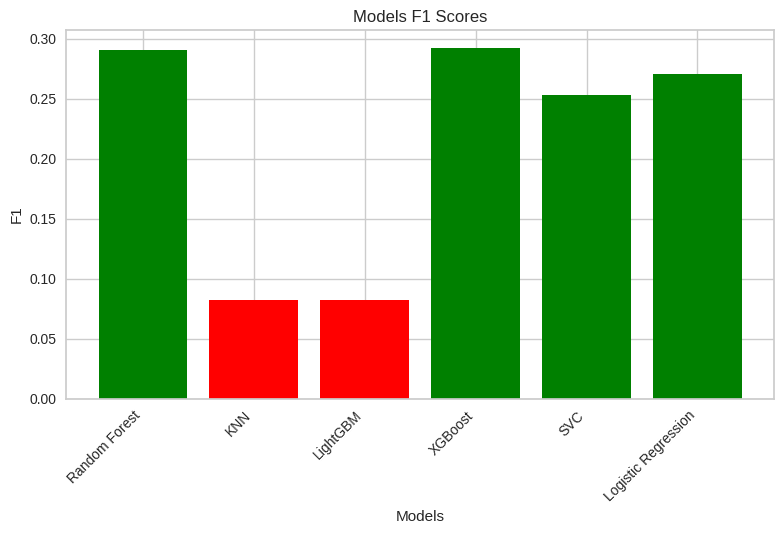

In [82]:
Models = list(models.keys())
F1 = results_df['F1-Score'].tolist()

color = ['green', 'red', 'red','green', 'green','green']


plt.bar(Models, F1, color=color)
plt.title('Models F1 Scores')
plt.xlabel('Models')
plt.ylabel('F1')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

The above bar graph is comparing the F1 scores of all the models. As you can see the two green bars (SVC and Logistic Regression) show the best F1 performance. Showing two clear better performing models compared to the rest.

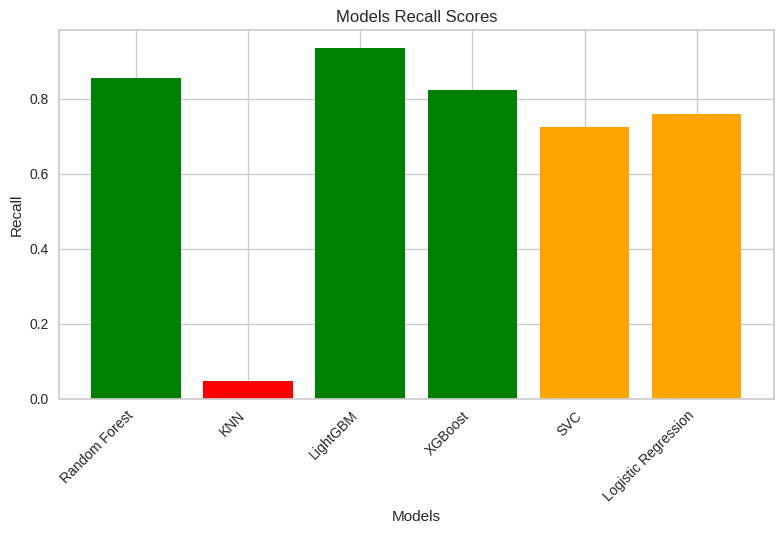

In [83]:
Models = list(models.keys())
Recall = results_df['Recall'].tolist()

color = ['green', 'red', 'green','green', 'orange','orange']

plt.bar(Models, Recall, color=color)
plt.title('Models Recall Scores')
plt.xlabel('Models')
plt.ylabel('Recall')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

The above bar graph is comparing the Recall scores of all the models. As you can see the two green bars (SVC and Logistic Regression) show the best Recall performance. Showing two clear better performing models compared to the rest.

The conclusion from the graphs comparing the models shows XGB and Random Forest the two top performers for F1 and AUC scores. LightGBM shows better perfomance testing the recall scores. However please note the SVC model is not finetuned due to execessive run time for the parameters. Taking all the information into account, the best performing and fastest model is XGB.

##Final Model

In [84]:
final_model = best_xgb_model

final_model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=125, n_jobs=None,
              num_parallel_tree=None, random_state=101, ...)

In [85]:
eval_metric(final_model,X_train, y_train, X_test, y_test)

Test_Set
[[724 236]
 [ 11  51]]
              precision    recall  f1-score   support

           0       0.99      0.75      0.85       960
           1       0.18      0.82      0.29        62

    accuracy                           0.76      1022
   macro avg       0.58      0.79      0.57      1022
weighted avg       0.94      0.76      0.82      1022

AUC (Test Set): 0.8548135080645162
------------------------------------
Train_Set
[[2914  987]
 [  26  161]]
              precision    recall  f1-score   support

           0       0.99      0.75      0.85      3901
           1       0.14      0.86      0.24       187

    accuracy                           0.75      4088
   macro avg       0.57      0.80      0.55      4088
weighted avg       0.95      0.75      0.82      4088

AUC (Train Set): 0.8757270520242308
------------------------------------


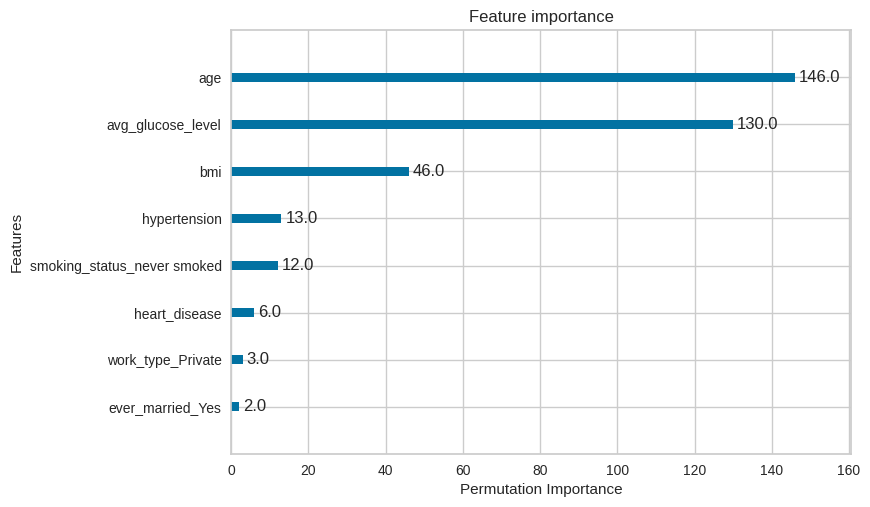

In [86]:
plot_importance(final_model, max_num_features=10)

perm_importance = permutation_importance(final_model, X_test, y_test, n_repeats=30,
                                         random_state=42)

sorted_idx = perm_importance.importances_mean.argsort()

plt.barh(X_test.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.show()


FINAL MODEL

In [87]:
import pickle

In [88]:
final_model.pkl = best_xgb_model
final_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=125, n_jobs=None,
              num_parallel_tree=None, random_state=101, ...)

In [89]:
pickle.dump(final_model, open('final_model.pkl', 'wb'))

In [90]:
pickle.dump(scaler,open('scaler.pkl', 'wb'))